In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [2]:
df_train = pd.read_csv("/content/sample_data/diabetes.csv",na_values = {'Glucose':0,
                                    'BloodPressure':0,
                                    'SkinThickness':0,
                                    'Insulin':0,
                                    'BMI':0})

In [3]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [4]:
df_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df_train.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [6]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing

Glucose            5
BMI               11
BloodPressure     35
SkinThickness    227
Insulin          374
dtype: int64

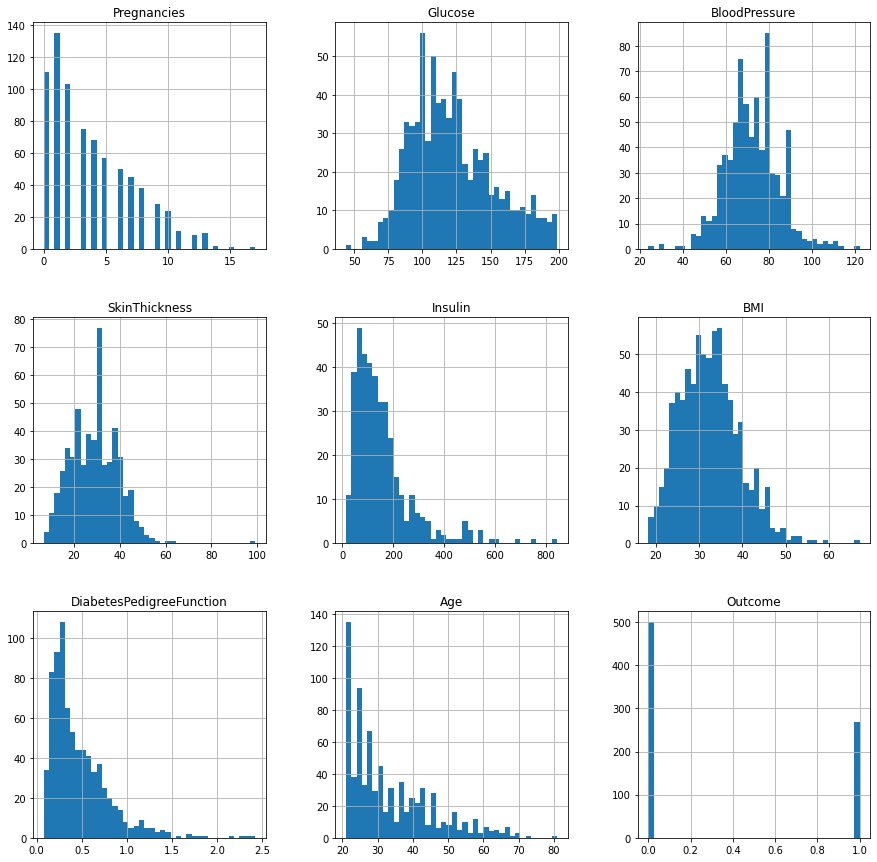

In [7]:
df_train.hist(bins = 40, figsize = (15,15))
plt.show()

In [8]:
df_train["Glucose_Cat"] = df_train["Glucose"].apply(lambda x: "Normal" if x < 140 else ("Prediabetes" if 140 <= x <= 199 else "Risk"))

In [9]:
df_train['Preg_Rate'] = df_train['Pregnancies'] / df_train['Age']

In [10]:
df_train["Insulin_Cat"] = df_train["Insulin"].apply(lambda x: "Normal" if (16 <= x <= 166) else "Abnormal")

In [11]:
# Fill NA of the column specified with the median and use specific columns to group by 
df_train['Glucose'] = df_train['Glucose'].fillna(df_train.groupby('Outcome')['Glucose'].transform('median'))
df_train['BMI'] = df_train['BMI'].fillna(df_train.groupby('Outcome')['BMI'].transform('median'))
df_train['Insulin'] = df_train['Insulin'].fillna(df_train.groupby(['Outcome','Glucose_Cat'])['Insulin'].transform('median'))
df_train['Insulin'] = df_train['Insulin'].fillna(df_train['Insulin'].median())
df_train['SkinThickness'] = df_train['SkinThickness'].fillna(df_train.groupby(['Outcome','Glucose_Cat'])['SkinThickness'].transform('mean'))
df_train['BloodPressure'] = df_train['BloodPressure'].fillna(df_train.groupby(['Outcome','Age','Glucose_Cat'])['BloodPressure'].transform('median'))
df_train['BloodPressure'] = df_train['BloodPressure'].fillna(df_train['BloodPressure'].median())

In [12]:
bmi_labels = ['Underweight','Healthy Weight','Overweight','Obesity']

df_train['BMI_Cat'] = pd.cut(df_train['BMI'],[0,18.5,25,30,df_train['BMI'].max()],labels=bmi_labels)

In [13]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing

Series([], dtype: int64)

In [14]:
correlation_matrix = df_train.corr()
correlation_matrix["Outcome"].sort_values(ascending = False)
correlation_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Preg_Rate
Pregnancies,1.000000,0.130155,0.214827,0.094373,0.059821,0.023890,-0.033523,0.544341,0.221898,0.920143
Glucose,0.130155,1.000000,0.227738,0.253567,0.578703,0.236171,0.138353,0.268910,0.495990,0.045904
BloodPressure,0.214827,0.227738,1.000000,0.202061,0.099416,0.285980,0.004008,0.333885,0.168099,0.107914
SkinThickness,0.094373,0.253567,0.202061,1.000000,0.218390,0.565817,0.104330,0.143589,0.305705,0.051465
Insulin,0.059821,0.578703,0.099416,0.218390,1.000000,0.249602,0.147390,0.156310,0.371153,0.010378
BMI,0.023890,0.236171,0.285980,0.565817,0.249602,1.000000,0.152771,0.027849,0.315577,-0.008616
DiabetesPedigreeFunction,-0.033523,0.138353,0.004008,0.104330,0.147390,0.152771,1.000000,0.033561,0.173844,-0.060263
Age,0.544341,0.268910,0.333885,0.143589,0.156310,0.027849,0.033561,1.000000,0.238356,0.258233
Outcome,0.221898,0.495990,0.168099,0.305705,0.371153,0.315577,0.173844,0.238356,1.000000,0.163744
Preg_Rate,0.920143,0.045904,0.107914,0.051465,0.010378,-0.008616,-0.060263,0.258233,0.163744,1.000000


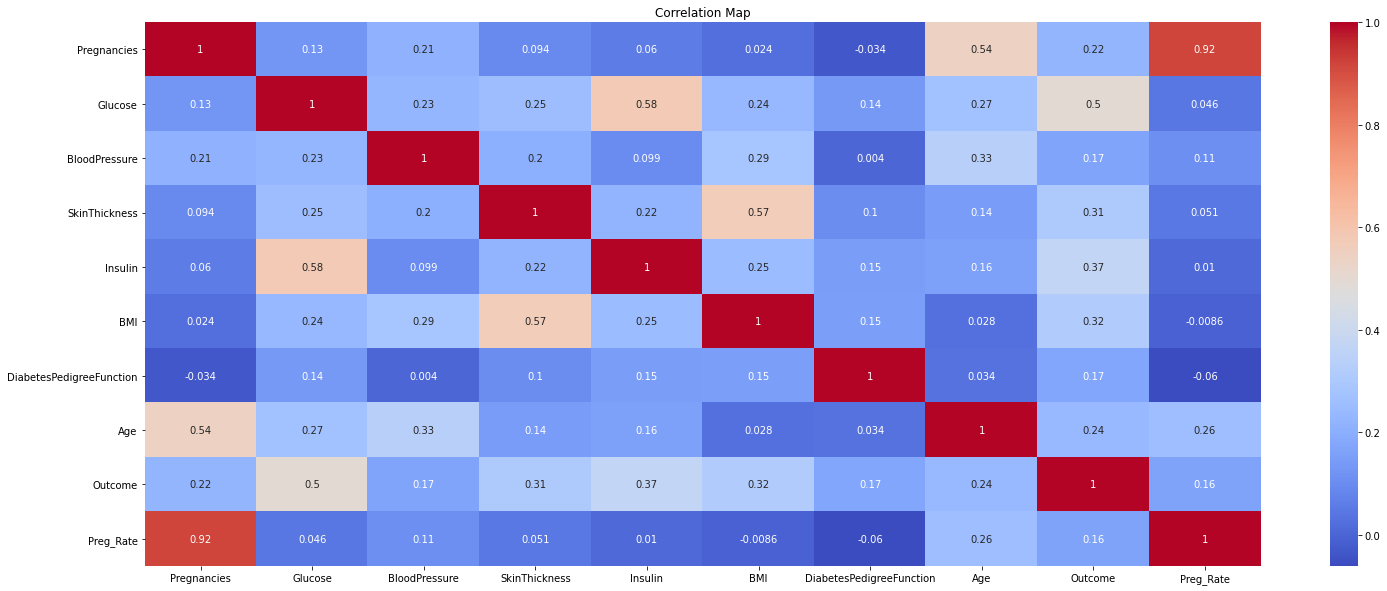

In [15]:
fig,ax= plt.subplots(figsize=(25,10))
sns.heatmap(correlation_matrix,cmap='coolwarm',annot=True)
plt.title('Correlation Map')
plt.show()

In [16]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] == 'int64' or df_train.dtypes[f] == 'float64' ]
quantitative.remove('Outcome')
quantitative

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Preg_Rate']

In [17]:
scaler = Normalizer()
df_train[quantitative] = scaler.fit_transform(df_train[quantitative])
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Cat,Preg_Rate,Insulin_Cat,BMI_Cat
0,0.022148,0.546313,0.265774,0.129196,0.751180,0.124028,0.002314,0.184565,1,Prediabetes,0.000443,Abnormal,Obesity
1,0.006604,0.561357,0.435877,0.191522,0.620794,0.175672,0.002318,0.204730,0,Normal,0.000213,Abnormal,Overweight
2,0.027980,0.640045,0.223841,0.117055,0.711744,0.081492,0.002350,0.111920,1,Prediabetes,0.000874,Abnormal,Healthy Weight
3,0.006612,0.588467,0.436392,0.152076,0.621527,0.185797,0.001104,0.138852,0,Normal,0.000315,Normal,Overweight
4,0.000000,0.596386,0.174127,0.152361,0.731335,0.187622,0.009960,0.143655,1,Normal,0.000000,Abnormal,Obesity


In [18]:
qualitative = ['Glucose_Cat','Insulin_Cat','BMI_Cat']

In [19]:
df_train[qualitative] = df_train[qualitative].apply(LabelEncoder().fit_transform)

In [36]:
X = df_train.drop('Outcome',axis=1)
X = X.drop('BloodPressure',axis = 1)
X = X.drop('Preg_Rate',axis = 1)                   
y = df_train['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

In [37]:
model = SVC(C = 0.8,kernel='linear',gamma='auto')
model.fit(X_train, y_train)
y_predict = model.predict(X_train)
print(f'The Training accuracy is {accuracy_score(y_train, y_predict)}')
y_pred_sklearn = model.predict(X_test)
print(f'The Testing accuracy is {accuracy_score(y_test, y_pred_sklearn)}')

The Training accuracy is 0.7280130293159609
The Testing accuracy is 0.8116883116883117


In [40]:
model = LogisticRegression(max_iter= 40)
model.fit(X_train,y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print(accuracy_score(y_train, train_predictions))
print(accuracy_score(y_test, test_predictions))

0.7263843648208469
0.8181818181818182


In [41]:
#Fit the KNN model
K=3
knn= KNeighborsClassifier(K)
knn.fit(X_train , y_train)
y_pred_sklearn = knn.predict(X_train)
print(f'The Training accuracy is {accuracy_score(y_train, y_pred_sklearn)}')
y_pred_sklearn = knn.predict(X_test)
print(f'The Testing accuracy is {accuracy_score(y_test, y_pred_sklearn)}')

The Training accuracy is 0.8908794788273615
The Testing accuracy is 0.8246753246753247
